In [1]:
import pandas as pd
import numpy as np
import pickle
today = pd.Timestamp.today().strftime('%Y-%m-%d')

# Read the data

In [2]:
NFA = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')['NFA']


dateindex = pd.date_range(start=NFA.index[0], 
                             end=NFA.index[-1] + pd.Timedelta(days=365),
                            freq='B')
exogs = pd.DataFrame(index=dateindex)

exogs['trend'] = np.arange(len(exogs))
# Define seasonalities based on your original expressions
exogs['yearly_season'] = np.sin(2 * np.pi * exogs['trend'] / 260)  # Assuming 260 working days per year for yearly seasonality
exogs['monthly_season'] = np.sin(2 * np.pi * exogs['trend'] / 22)  # Assuming about 22 working days per month
exogs['weekly_season'] = np.sin(2 * np.pi * exogs['trend'] / 5)   # Assuming 5 working days per week
exogs['break'] = np.where(exogs.index > '2020-01-06', 1, 0)

X = exogs
y = NFA

# Read the model

In [3]:
model = pickle.load(open('../model_output/NFA_forecast.pkl', 'rb'))

Importing plotly failed. Interactive plots will not work.


# Forecast

In [4]:
y_pred, y_pred_ints, preds, pred_ints = model.update(new_y=y, new_X=X,
                                                     mode='nbest_average_horizon',
                                                     ret_underlying=True)

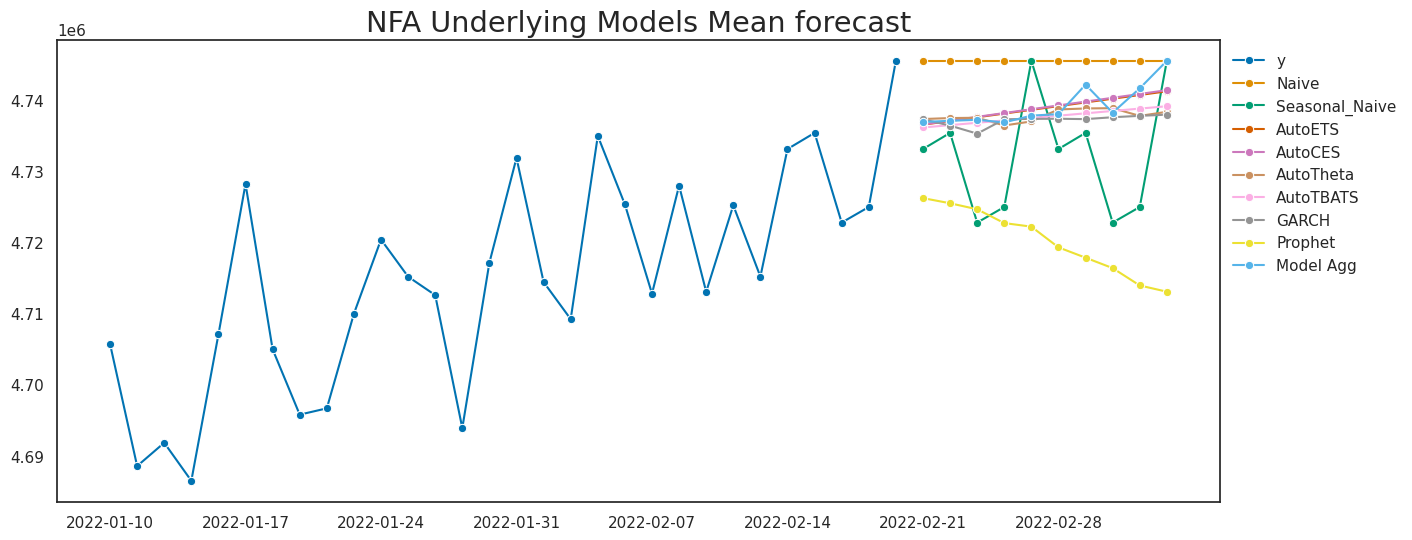

In [5]:
f, ax = model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     title = 'NFA Underlying Models Mean forecast',
                     y_pred_interval = None) 

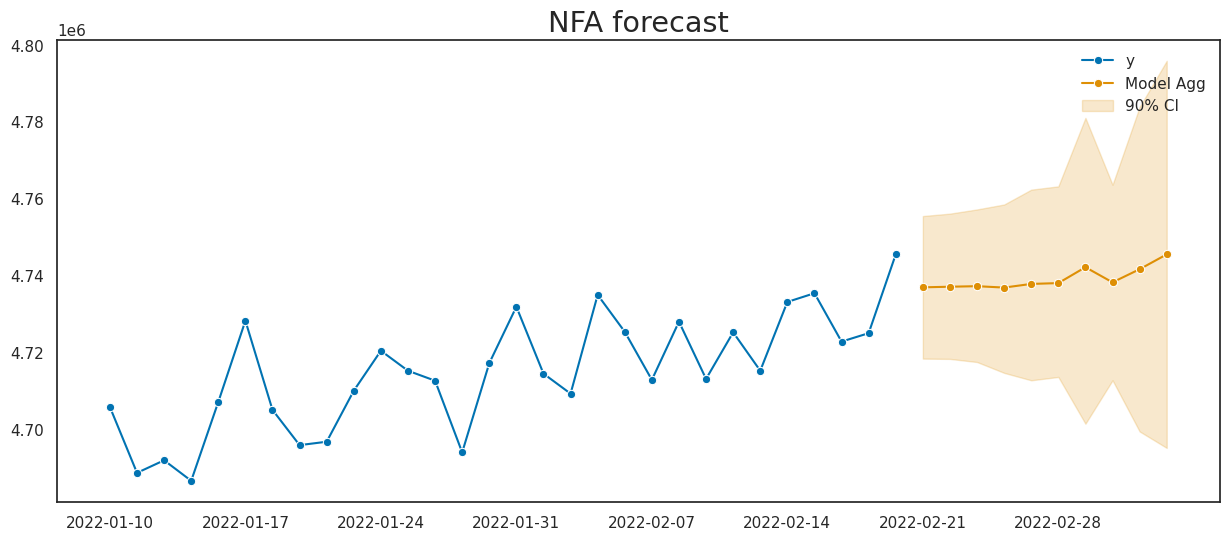

In [8]:
f, ax = model.plot_prediction(y_pred = y_pred,
                     models_preds = None,
                     title = 'NFA forecast',
                     y_pred_interval = y_pred_ints) 
f.savefig(f'forecast_output/NFA_forecast_{today}.png')
f.show()

## Save forecast output

In [7]:
with pd.ExcelWriter(f'forecast_output/NFA_prediction_{today}.xlsx') as writer:
    y_pred.rename('Model Agg').to_frame().to_excel(writer, sheet_name='mean_forecast', index=True)
    y_pred_ints.to_excel(writer, sheet_name='prediction_intervals', index=True)
    preds.to_excel(writer, sheet_name='underlying_models_forecasts', index=True)
    pred_ints.to_excel(writer, sheet_name='underlying_models_CI', index=True)